Content:

0. Load data

1. Random Forest

    1.1. Comparing performance of iterative and multiprocessing hyperparameter testing
    
    1.2. ROSE
    
    1.3. SMOTE
    
    1.4. Weights
    
2. XGBoost

    2.1. ROSE
    
    2.2. SMOTE
    
3. LightGBM

    3.1. ROSE
    
    3.2. SMOTE
    
    3.3. Weights

In [141]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from itertools import product
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier

from tools.clf_hyperparameters import run_inference, generate_hprs_report

# 0. Load data

In [30]:
df_rose = pd.read_csv(os.path.join('data', '.local', 'processed_data', 'ROSE_data.csv'))
df_smote = pd.read_csv(os.path.join('data', '.local', 'processed_data', 'SMOTE_data.csv'))
df_test = pd.read_csv(os.path.join('data', '.local', 'processed_data', 'TEST_data.csv'))
df_train = pd.read_csv(os.path.join('data', '.local', 'processed_data', 'TRAIN_data.csv'))

In [31]:
df_smote.head()

,operating gross margin,operating profit rate,tax rate (a),cash flow per share,revenue per share (yuan ¥),realized sales gross profit growth rate,operating profit growth rate,regular net profit growth rate,continuous net profit growth rate,total asset return growth rate ratio,...,cfo to assets,cash flow to equity,current liability to current assets,net income to total assets,total assets to gnp price,no-credit interval,degree of financial leverage (dfl),interest coverage ratio (interest expense to ebit),equity to liability,bankrupt
0,0.590359,0.998846,0.000000,0.316828,0.004522,0.021769,0.846914,0.689452,0.217600,0.264058,...,0.558819,0.313302,0.055387,0.781611,0.004655,0.627110,0.026640,0.564316,0.025340,0
1,0.610574,0.999015,0.061039,0.322664,0.012916,0.022123,0.848121,0.689442,0.217597,0.264028,...,0.592301,0.316221,0.019553,0.812792,0.010198,0.624033,0.026818,0.565281,0.056004,0
2,0.620908,0.999207,0.000000,0.338544,0.047129,0.022316,0.849140,0.691038,0.217782,0.266725,...,0.668492,0.325874,0.017948,0.879568,0.001569,0.624056,0.026791,0.565159,0.040519,0
3,0.595605,0.998836,0.000000,0.320330,0.007956,0.021980,0.847958,0.687889,0.217316,0.263687,...,0.589044,0.314346,0.069895,0.781655,0.001048,0.622837,0.026663,0.564460,0.046069,0
4,0.621903,0.999134,0.560684,0.318420,0.011737,0.022082,0.848022,0.689311,0.217578,0.264047,...,0.574052,0.307219,0.006455,0.810024,0.000784,0.624616,0.026791,0.565158,0.147779,0


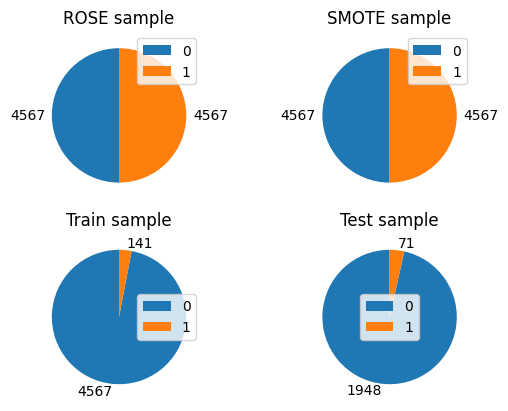

In [53]:
fig, axs = plt.subplots(2, 2)

X_rose = df_rose[df_rose.columns[:-1]].to_numpy()
Y_rose = df_rose['bankrupt'].to_numpy()
vc1 = pd.Series(Y_rose).value_counts()
axs[0, 0].pie(vc1.values, labels=vc1.values, startangle=90)
axs[0, 0].set_title('ROSE sample')
axs[0, 0].legend(vc1.index)

X_smote = df_smote[df_smote.columns[:-1]].to_numpy()
Y_smote = df_smote['bankrupt'].to_numpy()
vc2 = pd.Series(Y_smote).value_counts()
axs[0, 1].pie(vc2.values, labels=vc2.values, startangle=90)
axs[0, 1].set_title('SMOTE sample')
axs[0, 1].legend(vc2.index)

X_train = df_train[df_train.columns[:-1]].to_numpy()
Y_train = df_train['bankrupt'].to_numpy()
vc3 = pd.Series(Y_train).value_counts()
axs[1, 0].pie(vc3.values, labels=vc3.values, startangle=90)
axs[1, 0].set_title('Train sample')
axs[1, 0].legend(vc3.index)

X_test = df_test[df_test.columns[:-1]].to_numpy()
Y_test = df_test['bankrupt'].to_numpy()
vc4 = pd.Series(Y_test).value_counts()
axs[1, 1].pie(vc4.values, labels=vc4.values, startangle=90)
axs[1, 1].set_title('Test sample')
axs[1, 1].legend(vc4.index)

plt.show()

# 1. Random Forest

Hyperparameters

In [5]:
HPRS = ['n_estimators', 'max_depth', 'min_samples_leaf', 'max_features']

In [6]:
rf_params1 = {
    'n_estimators': [10, 50],
    'criterion': ['entropy'],
    'max_depth': [5, 20, 60],
    'min_samples_leaf': [2, 4, 6, 10],
    'max_features': [0.25, 0.5, 0.75]
}

In [7]:
rf_params2 = {
    'n_estimators': [10, 40, 80, 120, 200, 500, 1000],
    'criterion': ['entropy'],
    'max_depth': [3, 20, 40, 80, 120],
    'min_samples_leaf': [2, 5, 10, 20],
    'max_features': [0.1, 0.15, 0.25, 0.4, 0.6]
}

In [8]:
print('1st inference for demonstration purpose - compare iterative and multiprocessing approaches\n')
print("\n".join(re.split('(?<=]),', rf_params1.__str__())))
print("\nNumber of settups:", len(list(product(*list(rf_params1.values())))))

1st inference for demonstration purpose - compare iterative and multiprocessing approaches

{'n_estimators': [10, 50]
 'criterion': ['entropy']
 'max_depth': [5, 20, 60]
 'min_samples_leaf': [2, 4, 6, 10]
 'max_features': [0.25, 0.5, 0.75]}

Number of settups: 72


In [9]:
print('2st (main) inference \n')
print("\n".join(re.split('(?<=]),', rf_params2.__str__())))
print("\nNumber of settups:", len(list(product(*list(rf_params2.values())))))

2st (main) inference 

{'n_estimators': [10, 40, 80, 120, 200, 500, 1000]
 'criterion': ['entropy']
 'max_depth': [3, 20, 40, 80, 120]
 'min_samples_leaf': [2, 5, 10, 20]
 'max_features': [0.1, 0.15, 0.25, 0.4, 0.6]}

Number of settups: 700


## 1.1. Comparing performance of iterative and multiprocessing hyperparameter testing

In [69]:
run_inference(data=(X_rose, X_test, Y_rose, Y_test),
              base_clf=RandomForestClassifier,
              params=rf_params1,
              metrics=('f1-score', 'precision', 'recall'),
              classes=(0, 1),
              output_file=os.path.join('data', '.local', 'hprs', 'RF_it_results.csv'),
              multiprocessing_mode=False)

Number of classifiers to be trained: 72


Iterative method: 100%|█████████████████████████| 72/72 [01:18<00:00,  1.10s/it]

@timer:<function iterative at 0x7f511942d6c0> exec. time: 78.89 s.


In [11]:
run_inference(data=(X_rose, X_test, Y_rose, Y_test),
              base_clf=RandomForestClassifier,
              params=rf_params1,
              metrics=('f1-score', 'precision', 'recall'),
              classes=(0, 1),
              output_file=os.path.join('data', '.local', 'hprs', 'RF_mp_results.csv'),
              multiprocessing_mode=True)

Number of classifiers to be trained: 72


Multiprocessing method: 100%|███████████████████| 72/72 [00:10<00:00,  6.87it/s]

Results writen into data/.local/hprs/RF_mp_results.csv.
@timer:<function processes at 0x7ffb650b9900> exec. time: 10.7 s.


## 1.2. ROSE

In [71]:
run_inference(data=(X_rose, X_test, Y_rose, Y_test),
              base_clf=RandomForestClassifier,
              params=rf_params2,
              metrics=('f1-score', 'precision', 'recall'),
              classes=(0, 1),
              output_file=os.path.join('data', '.local', 'hprs', 'RF_ROSE_results.csv'),
              multiprocessing_mode=True)

Number of classifiers to be trained: 700


Multiprocessing method: 100%|█████████████████| 700/700 [10:01<00:00,  1.16it/s]

Results writen into data/.local/hprs/RF_ROSE_results.csv.
@timer:<function processes at 0x7f511942d7e0> exec. time: 601.4 s.


In [10]:
rf_rose_res = pd.read_csv(os.path.join('data', '.local', 'hprs', 'RF_ROSE_results.csv'), sep=';')
rf_rose_res

,n_estimators,criterion,max_depth,min_samples_leaf,max_features,f1-score_0,f1-score_1,precision_0,precision_1,recall_0,recall_1
0,10,entropy,3,5,0.10,0.890206,0.214141,0.988715,0.125000,0.809548,0.746479
1,10,entropy,3,5,0.15,0.890771,0.218182,0.989342,0.127358,0.810062,0.760563
2,10,entropy,3,10,0.15,0.890771,0.218182,0.989342,0.127358,0.810062,0.760563
3,10,entropy,3,2,0.15,0.890771,0.218182,0.989342,0.127358,0.810062,0.760563
4,10,entropy,3,2,0.10,0.890206,0.214141,0.988715,0.125000,0.809548,0.746479
...,...,...,...,...,...,...,...,...,...,...,...
695,1000,entropy,120,10,0.40,0.976589,0.397351,0.978855,0.375000,0.974333,0.422535
696,1000,entropy,120,5,0.60,0.980843,0.390244,0.976106,0.461538,0.985626,0.338028
697,1000,entropy,120,20,0.40,0.969886,0.376344,0.981092,0.304348,0.958932,0.492958
698,1000,entropy,120,10,0.60,0.974478,0.377358,0.978767,0.340909,0.970226,0.422535


In [11]:
generate_hprs_report(df=rf_rose_res, hprs=HPRS, metrics=['f1-score_1', 'precision_1', 'recall_1'])

		Hyperparameters Report

	Correlation between given metrics and hyperparameters

	---f1-score_1---

              f1-score_1
max_features   -0.220783

	---precision_1---

              precision_1
max_features     0.065483

	---recall_1---

              recall_1
max_features  0.091888


	Best setups per metric

	---f1-score_1---

     n_estimators  max_depth  min_samples_leaf  max_features  f1-score_1
181            40        120                 5          0.15    0.450000
226            80         20                10          0.15    0.445860
190            40        120                10          0.25    0.433121
162            40         80                10          0.10    0.430380
273            80         80                 5          0.40    0.428571

	---precision_1---

     n_estimators  max_depth  min_samples_leaf  max_features  precision_1
118            40         20                 2          0.15     0.583333
548           500         40                 2          0.4

## 1.3. SMOTE

In [75]:
run_inference(data=(X_rose, X_test, Y_rose, Y_test),
              base_clf=RandomForestClassifier,
              params=rf_params2,
              metrics=('f1-score', 'precision', 'recall'),
              classes=(0, 1),
              output_file=os.path.join('data', '.local', 'hprs', 'RF_SMOTE_results.csv'),
              multiprocessing_mode=True)

Number of classifiers to be trained: 700


Multiprocessing method: 100%|█████████████████| 700/700 [08:53<00:00,  1.31it/s]

Results writen into data/.local/hprs/RF_SMOTE_results.csv.
@timer:<function processes at 0x7f511942d7e0> exec. time: 534.23 s.


In [56]:
rf_smote_res = pd.read_csv(os.path.join('data', '.local', 'hprs', 'RF_SMOTE_results.csv'), sep=';')
rf_smote_res.head()

,n_estimators,criterion,max_depth,min_samples_leaf,max_features,f1-score_0,f1-score_1,precision_0,precision_1,recall_0,recall_1
0,10,entropy,3,5,0.10,0.890206,0.214141,0.988715,0.125000,0.809548,0.746479
1,10,entropy,3,10,0.10,0.890206,0.214141,0.988715,0.125000,0.809548,0.746479
2,10,entropy,3,2,0.10,0.890206,0.214141,0.988715,0.125000,0.809548,0.746479
3,10,entropy,3,5,0.15,0.890771,0.218182,0.989342,0.127358,0.810062,0.760563
4,10,entropy,3,2,0.15,0.890771,0.218182,0.989342,0.127358,0.810062,0.760563


In [13]:
generate_hprs_report(df=rf_smote_res, hprs=HPRS, metrics=['f1-score_1', 'precision_1', 'recall_1'])

		Hyperparameters Report

	Correlation between given metrics and hyperparameters

	---f1-score_1---

              f1-score_1
max_features   -0.195935

	---precision_1---

              precision_1
max_features     0.115412

	---recall_1---

              recall_1
max_features -0.004612


	Best setups per metric

	---f1-score_1---

     n_estimators  max_depth  min_samples_leaf  max_features  f1-score_1
190            40        120                10          0.25    0.454545
100            10        120                10          0.60    0.443038
591           500        120                10          0.25    0.428571
696          1000        120                 5          0.60    0.422764
151            40         40                10          0.25    0.421053

	---precision_1---

     n_estimators  max_depth  min_samples_leaf  max_features  precision_1
359           120         80                 2          0.25     0.586207
423           200         20                 2          0.2

## 1.4. Weights

In [21]:
rf_params_wght = rf_params2.copy()
rf_params_wght['class_weight'] = [
        {0: 1, 1: 2},
        {0: 1, 1: 4},
        {0: 1, 1: 8},
        {0: 1, 1: 12}
    ]

In [79]:
run_inference(data=(X_train, X_test, Y_train, Y_test),
              base_clf=RandomForestClassifier,
              params=rf_params_wght,
              metrics=('f1-score', 'precision', 'recall'),
              classes=(0, 1),
              output_file=os.path.join('data', '.local', 'hprs', 'RF_WEIGHTS_results.csv'),
              multiprocessing_mode=True)

Number of classifiers to be trained: 2800


Multiprocessing method: 100%|███████████████| 2800/2800 [22:56<00:00,  2.03it/s]

Results writen into data/.local/hprs/RF_WEIGHTS_results.csv.
@timer:<function processes at 0x7f511942d7e0> exec. time: 1376.64 s.


In [55]:
rf_weights_res = pd.read_csv(os.path.join('data', '.local', 'hprs', 'RF_WEIGHTS_results.csv'), sep=';')
rf_weights_res.head()

,n_estimators,criterion,max_depth,min_samples_leaf,max_features,class_weight,f1-score_0,f1-score_1,precision_0,precision_1,recall_0,recall_1
0,10,entropy,3,2,0.10,"{0: 1, 1: 4}",0.977562,0.241379,0.971125,0.311111,0.984086,0.197183
1,10,entropy,3,2,0.10,"{0: 1, 1: 12}",0.959243,0.340426,0.983288,0.243902,0.936345,0.563380
2,10,entropy,3,2,0.10,"{0: 1, 1: 2}",0.982846,0.081081,0.966270,1.000000,1.000000,0.042254
3,10,entropy,3,2,0.10,"{0: 1, 1: 8}",0.969179,0.327684,0.978045,0.273585,0.960472,0.408451
4,10,entropy,3,2,0.15,"{0: 1, 1: 4}",0.978604,0.250000,0.971183,0.341463,0.986140,0.197183


In [16]:
generate_hprs_report(df=rf_weights_res,
                     hprs=HPRS + ['class_weight'],
                     metrics=['f1-score_1', 'precision_1', 'recall_1'])

		Hyperparameters Report

	Correlation between given metrics and hyperparameters

	---f1-score_1---

              f1-score_1
max_features    0.022225

	---precision_1---

              precision_1
max_features    -0.028143

	---recall_1---

              recall_1
max_features  0.011594


	Best setups per metric

	---f1-score_1---

      n_estimators  max_depth  min_samples_leaf  max_features   class_weight   
1156            80        120                10           0.1  {0: 1, 1: 12}  \
329             10         80                20           0.6  {0: 1, 1: 12}   
1191            80        120                10           0.6   {0: 1, 1: 8}   
1877           200         80                10           0.1  {0: 1, 1: 12}   
229             10         40                10           0.6  {0: 1, 1: 12}   

      f1-score_1  
1156    0.441558  
329     0.438202  
1191    0.437956  
1877    0.437086  
229     0.430380  

	---precision_1---

      n_estimators  max_depth  min_samples_leaf  m

# 2. XGBoost

In [17]:
xgb_params = {'n_estimators': [10, 50, 100, 200, 500],
              'criterion': ['squared_error'],
              'max_depth': [2, 5, 10, 50, 100],
              'min_samples_leaf': [2, 10, 20, 50],
              'max_features': [round(0.1 * x, 1) for x in range(3, 6)],
             'learning_rate': [0.05, 0.1, 0.15]}

XGB_HPR = list(xgb_params.keys())
XGB_HPR.remove('criterion')

print("\n".join(re.split('(?<=]),', xgb_params.__str__())))
print("\nNumber of settups:", len(list(product(*list(xgb_params.values())))))

{'n_estimators': [10, 50, 100, 200, 500]
 'criterion': ['squared_error']
 'max_depth': [2, 5, 10, 50, 100]
 'min_samples_leaf': [2, 10, 20, 50]
 'max_features': [0.3, 0.4, 0.5]
 'learning_rate': [0.05, 0.1, 0.15]}

Number of settups: 900


## 2.1. ROSE

In [82]:
run_inference(data=(X_rose, X_test, Y_rose, Y_test),
              base_clf=GradientBoostingClassifier,
              params=xgb_params,
              metrics=('f1-score', 'precision', 'recall'),
              classes=(0, 1),
              output_file=os.path.join('data', '.local', 'hprs', 'XGB_ROSE_results.csv'),
              multiprocessing_mode=True)

Number of classifiers to be trained: 900


Multiprocessing method: 100%|█████████████████| 900/900 [19:49<00:00,  1.32s/it]

Results writen into data/.local/hprs/XGB_ROSE_results.csv.
@timer:<function processes at 0x7f511942d7e0> exec. time: 1189.56 s.


In [54]:
xgb_rose_res = pd.read_csv(os.path.join('data', '.local', 'hprs', 'XGB_ROSE_results.csv'), sep=';')
xgb_rose_res.head()

,n_estimators,criterion,max_depth,min_samples_leaf,max_features,learning_rate,f1-score_0,f1-score_1,precision_0,precision_1,recall_0,recall_1
0,10,squared_error,2,2,0.3,0.05,0.909847,0.249423,0.989740,0.149171,0.841889,0.760563
1,10,squared_error,2,10,0.3,0.10,0.910803,0.247664,0.989170,0.148459,0.843943,0.746479
2,10,squared_error,2,10,0.3,0.15,0.916001,0.250614,0.988116,0.151786,0.853696,0.718310
3,10,squared_error,2,2,0.3,0.10,0.910803,0.247664,0.989170,0.148459,0.843943,0.746479
4,10,squared_error,2,10,0.3,0.05,0.909847,0.249423,0.989740,0.149171,0.841889,0.760563


In [19]:
generate_hprs_report(df=xgb_rose_res, hprs=XGB_HPR, metrics=['f1-score_1', 'precision_1', 'recall_1'])

		Hyperparameters Report

	Correlation between given metrics and hyperparameters

	---f1-score_1---

                  f1-score_1
n_estimators        0.045309
max_depth          -0.151274
min_samples_leaf    0.072682
max_features       -0.030967
learning_rate      -0.048667

	---precision_1---

                  precision_1
n_estimators         0.271340
max_depth            0.080876
min_samples_leaf     0.004530
max_features         0.076969
learning_rate        0.079269

	---recall_1---

                  recall_1
n_estimators     -0.143214
max_depth        -0.380686
min_samples_leaf  0.001307
max_features     -0.030785
learning_rate    -0.028696


	Best setups per metric

	---f1-score_1---

     n_estimators  max_depth  min_samples_leaf  max_features  learning_rate   
233            50          5                20           0.3           0.15  \
409           100          5                10           0.4           0.10   
397           100          5                 2           0.3 

## 2.2. SMOTE

In [85]:
run_inference(data=(X_rose, X_test, Y_rose, Y_test),
              base_clf=GradientBoostingClassifier,
              params=xgb_params,
              metrics=('f1-score', 'precision', 'recall'),
              classes=(0, 1),
              output_file=os.path.join('data', '.local', 'hprs', 'XGB_SMOTE_results.csv'),
              multiprocessing_mode=True)

Number of classifiers to be trained: 900


Multiprocessing method: 100%|█████████████████| 900/900 [19:42<00:00,  1.31s/it]

Results writen into data/.local/hprs/XGB_SMOTE_results.csv.
@timer:<function processes at 0x7f511942d7e0> exec. time: 1182.89 s.


In [57]:
xgb_smote_res = pd.read_csv(os.path.join('data', '.local', 'hprs', 'XGB_SMOTE_results.csv'), sep=';')
xgb_smote_res.head()

,n_estimators,criterion,max_depth,min_samples_leaf,max_features,learning_rate,f1-score_0,f1-score_1,precision_0,precision_1,recall_0,recall_1
0,10,squared_error,2,2,0.3,0.15,0.916001,0.250614,0.988116,0.151786,0.853696,0.718310
1,10,squared_error,2,2,0.3,0.10,0.910803,0.247664,0.989170,0.148459,0.843943,0.746479
2,10,squared_error,2,10,0.3,0.15,0.916001,0.250614,0.988116,0.151786,0.853696,0.718310
3,10,squared_error,2,10,0.3,0.05,0.909847,0.249423,0.989740,0.149171,0.841889,0.760563
4,10,squared_error,2,10,0.3,0.10,0.910803,0.247664,0.989170,0.148459,0.843943,0.746479


In [21]:
generate_hprs_report(df=xgb_smote_res,
                     hprs=XGB_HPR,
                     metrics=['f1-score_1', 'precision_1', 'recall_1'])

		Hyperparameters Report

	Correlation between given metrics and hyperparameters

	---f1-score_1---

                  f1-score_1
n_estimators        0.008010
max_depth          -0.060919
min_samples_leaf    0.077338
max_features       -0.053732
learning_rate      -0.075934

	---precision_1---

                  precision_1
n_estimators         0.272390
max_depth            0.115440
min_samples_leaf     0.031735
max_features         0.081481
learning_rate        0.121909

	---recall_1---

                  recall_1
n_estimators     -0.148443
max_depth        -0.406398
min_samples_leaf  0.022417
max_features     -0.036045
learning_rate    -0.025242


	Best setups per metric

	---f1-score_1---

     n_estimators  max_depth  min_samples_leaf  max_features  learning_rate   
243            50          5                50           0.3           0.15  \
595           200          5                20           0.4           0.05   
606           200          5                50           0.4 

## 2.3. Weights - no such parameter in XGBoost

# 3. LightGBM

In [19]:
lgbm_params = {'num_leaves': [20, 50, 100],
               'max_depth': [2, 10, 100],
               'learning_rate': [0.01, 0.05, 0.1],
               'n_estimators': [50, 100, 500, 1000],
               'min_child_samples': [10, 50, 100],
               'objective': ['binary'],
               'colsample_bytree': [round(0.1 * x, 1) for x in range(2, 8, 2)],
               'reg_alpha': [0, 0.01, 0.1],
               'verbose': [-1]
              }
LGBM_HPRS = list(lgbm_params.keys())
LGBM_HPRS.remove('objective')
LGBM_HPRS.remove('verbose')


print("\n".join(re.split('(?<=]),', lgbm_params.__str__())))
print("\nNumber of settups:", len(list(product(*list(lgbm_params.values())))))

{'num_leaves': [20, 50, 100]
 'max_depth': [2, 10, 100]
 'learning_rate': [0.01, 0.05, 0.1]
 'n_estimators': [50, 100, 500, 1000]
 'min_child_samples': [10, 50, 100]
 'objective': ['binary']
 'colsample_bytree': [0.2, 0.4, 0.6]
 'reg_alpha': [0, 0.01, 0.1]
 'verbose': [-1]}

Number of settups: 2916


## 3.1. ROSE

In [16]:
run_inference(data=(X_rose, X_test, Y_rose, Y_test),
              base_clf=LGBMClassifier,
              params=lgbm_params,
              metrics=('f1-score', 'precision', 'recall'),
              classes=(0, 1),
              output_file=os.path.join('data', '.local', 'hprs', 'LGBM_ROSE_results.csv'),
              multiprocessing_mode=False)

Number of classifiers to be trained: 2916


Iterative method: 100%|█████████████████████| 2916/2916 [08:51<00:00,  5.49it/s]

@timer:<function iterative at 0x7ffb650b97e0> exec. time: 531.24 s.


In [58]:
lgbm_rose_res = pd.read_csv(os.path.join('data', '.local', 'hprs', 'LGBM_ROSE_results.csv'), sep=';')
lgbm_rose_res.head()

,num_leaves,max_depth,learning_rate,n_estimators,min_child_samples,objective,colsample_bytree,reg_alpha,verbose,f1-score_0,f1-score_1,precision_0,precision_1,recall_0,recall_1
0,20,2,0.01,50,10,binary,0.2,0.00,-1,0.892837,0.227642,0.990613,0.133017,0.812628,0.788732
1,20,2,0.01,50,10,binary,0.2,0.01,-1,0.892837,0.227642,0.990613,0.133017,0.812628,0.788732
2,20,2,0.01,50,10,binary,0.2,0.10,-1,0.892837,0.227642,0.990613,0.133017,0.812628,0.788732
3,20,2,0.01,50,10,binary,0.4,0.00,-1,0.897191,0.234310,0.990695,0.137592,0.819815,0.788732
4,20,2,0.01,50,10,binary,0.4,0.01,-1,0.897191,0.234310,0.990695,0.137592,0.819815,0.788732


In [25]:
generate_hprs_report(df=lgbm_rose_res, hprs=LGBM_HPRS, metrics=['f1-score_1', 'precision_1', 'recall_1'])

		Hyperparameters Report

	Correlation between given metrics and hyperparameters

	---f1-score_1---

                   f1-score_1
num_leaves          -0.118143
max_depth            0.076159
learning_rate       -0.107031
n_estimators        -0.160904
min_child_samples    0.137347
colsample_bytree    -0.048935
reg_alpha           -0.054826

	---precision_1---

                   precision_1
num_leaves            0.109554
max_depth             0.158254
learning_rate         0.069332
n_estimators          0.379766
min_child_samples    -0.096006
colsample_bytree     -0.021005
reg_alpha            -0.090732

	---recall_1---

                   recall_1
num_leaves         0.036712
max_depth         -0.370675
learning_rate     -0.153834
n_estimators      -0.214804
min_child_samples -0.025535
colsample_bytree   0.028260
reg_alpha         -0.028036


	Best setups per metric

	---f1-score_1---

      num_leaves  max_depth  learning_rate  n_estimators  min_child_samples   
1537          50       

## 3.2. SMOTE

In [19]:
run_inference(data=(X_smote, X_test, Y_smote, Y_test),
              base_clf=LGBMClassifier,
              params=lgbm_params,
              metrics=('f1-score', 'precision', 'recall'),
              classes=(0, 1),
              output_file=os.path.join('data', '.local', 'hprs', 'LGBM_SMOTE_results.csv'),
              multiprocessing_mode=False)

Number of classifiers to be trained: 2916


Iterative method: 100%|█████████████████████| 2916/2916 [10:24<00:00,  4.67it/s]

@timer:<function iterative at 0x7ffb650b97e0> exec. time: 624.06 s.


In [59]:
lgbm_smote_res = pd.read_csv(os.path.join('data', '.local', 'hprs', 'LGBM_SMOTE_results.csv'), sep=';')
lgbm_smote_res.head()

,num_leaves,max_depth,learning_rate,n_estimators,min_child_samples,objective,colsample_bytree,reg_alpha,verbose,f1-score_0,f1-score_1,precision_0,precision_1,recall_0,recall_1
0,20,2,0.01,50,10,binary,0.2,0.00,-1,0.910601,0.240000,0.987988,0.144068,0.844456,0.718310
1,20,2,0.01,50,10,binary,0.2,0.01,-1,0.910601,0.240000,0.987988,0.144068,0.844456,0.718310
2,20,2,0.01,50,10,binary,0.2,0.10,-1,0.910601,0.240000,0.987988,0.144068,0.844456,0.718310
3,20,2,0.01,50,10,binary,0.4,0.00,-1,0.925633,0.256131,0.986071,0.158784,0.872177,0.661972
4,20,2,0.01,50,10,binary,0.4,0.01,-1,0.925633,0.256131,0.986071,0.158784,0.872177,0.661972


In [20]:
generate_hprs_report(df=lgbm_smote_res, hprs=LGBM_HPRS, metrics=['f1-score_1', 'precision_1', 'recall_1'])

		Hyperparameters Report

	Correlation between given metrics and hyperparameters

	---f1-score_1---

                  f1-score_1
learning_rate      -0.145909
colsample_bytree    0.037195
reg_alpha           0.027821

	---precision_1---

                  precision_1
learning_rate        0.183513
colsample_bytree     0.013412
reg_alpha           -0.096041

	---recall_1---

                  recall_1
learning_rate    -0.133063
colsample_bytree -0.107804
reg_alpha        -0.011300


	Best setups per metric

	---f1-score_1---

      num_leaves  max_depth  learning_rate  n_estimators  min_child_samples   
2894         100        100           0.10          1000                 10  \
2867         100        100           0.10           500                 10   
2757         100        100           0.05           500                 10   
2419         100         10           0.05           100                 50   
918           20        100           0.10           500                 10

## 3.3. Weights

In [22]:
lgbm_wghts_params = lgbm_params.copy()
lgbm_wghts_params['class_weight'] = [
    {0: 1, 1: 2},
    {0: 1, 1: 4},
    {0: 1, 1: 8},
    {0: 1, 1: 12}
]

LGBM_WGHTS_HPRS = list(lgbm_wghts_params.keys())
LGBM_WGHTS_HPRS.remove('objective')

print("\n".join(re.split('(?<=]),', lgbm_wghts_params.__str__())))
print("\nNumber of settups:", len(list(product(*list(lgbm_wghts_params.values())))))

{'num_leaves': [20, 50, 100]
 'max_depth': [2, 10, 100]
 'learning_rate': [0.01, 0.05, 0.1]
 'n_estimators': [50, 100, 500, 1000]
 'min_child_samples': [10, 50, 100]
 'objective': ['binary']
 'colsample_bytree': [0.2, 0.4, 0.6]
 'reg_alpha': [0, 0.01, 0.1]
 'verbose': [-1]
 'class_weight': [{0: 1, 1: 2}, {0: 1, 1: 4}, {0: 1, 1: 8}, {0: 1, 1: 12}]}

Number of settups: 11664


In [26]:
run_inference(data=(X_smote, X_test, Y_smote, Y_test),
              base_clf=LGBMClassifier,
              params=lgbm_wghts_params,
              metrics=('f1-score', 'precision', 'recall'),
              classes=(0, 1),
              output_file=os.path.join('data', '.local', 'hprs', 'LGBM_WEIGHTS_results.csv'),
              multiprocessing_mode=False)

Number of classifiers to be trained: 11664


Iterative method: 100%|█████████████████| 11664/11664 [1:23:14<00:00,  2.34it/s]

@timer:<function iterative at 0x7fd6b53b5750> exec. time: 4994.8 s.


In [60]:
lgbm_weights_res = pd.read_csv(os.path.join('data', '.local', 'hprs', 'LGBM_WEIGHTS_results.csv'), sep=';')
lgbm_weights_res.head()

,num_leaves,max_depth,learning_rate,n_estimators,min_child_samples,objective,colsample_bytree,reg_alpha,verbose,class_weight,f1-score_0,f1-score_1,precision_0,precision_1,recall_0,recall_1
0,20,2,0.01,50,10,binary,0.2,0.00,-1,"{0: 1, 1: 2}",0.713531,0.138889,0.999076,0.074707,0.554928,0.985915
1,20,2,0.01,50,10,binary,0.2,0.00,-1,"{0: 1, 1: 4}",0.000000,0.067943,0.000000,0.035166,0.000000,1.000000
2,20,2,0.01,50,10,binary,0.2,0.00,-1,"{0: 1, 1: 8}",0.000000,0.067943,0.000000,0.035166,0.000000,1.000000
3,20,2,0.01,50,10,binary,0.2,0.00,-1,"{0: 1, 1: 12}",0.000000,0.067943,0.000000,0.035166,0.000000,1.000000
4,20,2,0.01,50,10,binary,0.2,0.01,-1,"{0: 1, 1: 2}",0.713531,0.138889,0.999076,0.074707,0.554928,0.985915


In [28]:
generate_hprs_report(df=lgbm_weights_res, hprs=LGBM_WGHTS_HPRS, metrics=['f1-score_1', 'precision_1', 'recall_1'])

		Hyperparameters Report

	Correlation between given metrics and hyperparameters

	---f1-score_1---

                  f1-score_1
learning_rate       0.052293
colsample_bytree    0.044403
reg_alpha           0.006859

	---precision_1---

                  precision_1
learning_rate        0.190922
colsample_bytree     0.051845
reg_alpha           -0.106000

	---recall_1---

                  recall_1
learning_rate    -0.375888
colsample_bytree -0.000997
reg_alpha        -0.001628


	Best setups per metric

	---f1-score_1---

       num_leaves  max_depth  learning_rate  n_estimators  min_child_samples   
6277           50         10           0.10           500                 10  \
2461           20         10           0.10           500                100   
7552           50        100           0.10           100                100   
9756          100         10           0.05           500                 50   
11064         100        100           0.05           500             

# 4. Report

In [318]:
rf_rose_res = pd.read_csv(os.path.join('data', '.local', 'hprs', 'RF_ROSE_results.csv'), sep=';')
rf_smote_res = pd.read_csv(os.path.join('data', '.local', 'hprs', 'RF_SMOTE_results.csv'), sep=';')
rf_weights_res = pd.read_csv(os.path.join('data', '.local', 'hprs', 'RF_WEIGHTS_results.csv'), sep=';')
xgb_rose_res = pd.read_csv(os.path.join('data', '.local', 'hprs', 'XGB_ROSE_results.csv'), sep=';')
xgb_smote_res = pd.read_csv(os.path.join('data', '.local', 'hprs', 'XGB_SMOTE_results.csv'), sep=';')
lgbm_rose_res = pd.read_csv(os.path.join('data', '.local', 'hprs', 'LGBM_ROSE_results.csv'), sep=';')
lgbm_smote_res = pd.read_csv(os.path.join('data', '.local', 'hprs', 'LGBM_SMOTE_results.csv'), sep=';')
lgbm_weights_res = pd.read_csv(os.path.join('data', '.local', 'hprs', 'LGBM_WEIGHTS_results.csv'), sep=';')

In [64]:
rf_rose_res['clf'] = 'Random Forest'
rf_smote_res['clf'] = 'Random Forest'
rf_weights_res['clf'] = 'Random Forest'
xgb_rose_res['clf'] = 'XGBoost'
xgb_smote_res['clf'] = 'XGBoost'
lgbm_rose_res['clf'] = 'LightGBM'
lgbm_smote_res['clf'] = 'LightGBM'
lgbm_weights_res['clf'] = 'LightGBM'

rf_rose_res['method'] = 'ROSE'
rf_smote_res['method'] = 'SMOTE'
rf_weights_res['method'] = 'weights'
xgb_rose_res['method'] = 'ROSE'
xgb_smote_res['method'] = 'SMOTE'
lgbm_rose_res['method'] = 'ROSE'
lgbm_smote_res['method'] = 'SMOTE'
lgbm_weights_res['method'] = 'weights'

In [71]:
df_report = pd.concat([
    rf_rose_res,
    rf_smote_res,
    rf_weights_res,
    xgb_rose_res,
    xgb_smote_res,
    lgbm_rose_res,
    lgbm_smote_res,
    lgbm_weights_res
], axis=0)
df_report.drop(columns=['verbose', 'objective'], inplace=True)

In [75]:
df_report

,n_estimators,criterion,max_depth,min_samples_leaf,max_features,f1-score_0,f1-score_1,precision_0,precision_1,recall_0,recall_1,clf,method,class_weight,learning_rate,num_leaves,min_child_samples,colsample_bytree,reg_alpha
0,10,entropy,3,5.0,0.10,0.890206,0.214141,0.988715,0.125000,0.809548,0.746479,Random Forest,ROSE,NaN,NaN,NaN,NaN,NaN,NaN
1,10,entropy,3,5.0,0.15,0.890771,0.218182,0.989342,0.127358,0.810062,0.760563,Random Forest,ROSE,NaN,NaN,NaN,NaN,NaN,NaN
2,10,entropy,3,10.0,0.15,0.890771,0.218182,0.989342,0.127358,0.810062,0.760563,Random Forest,ROSE,NaN,NaN,NaN,NaN,NaN,NaN
3,10,entropy,3,2.0,0.15,0.890771,0.218182,0.989342,0.127358,0.810062,0.760563,Random Forest,ROSE,NaN,NaN,NaN,NaN,NaN,NaN
4,10,entropy,3,2.0,0.10,0.890206,0.214141,0.988715,0.125000,0.809548,0.746479,Random Forest,ROSE,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11659,1000,NaN,100,NaN,NaN,0.978658,0.442953,0.980422,0.423077,0.976899,0.464789,LightGBM,weights,"{0: 1, 1: 12}",0.1,100.0,100.0,0.6,0.01
11660,1000,NaN,100,NaN,NaN,0.977915,0.402778,0.978417,0.397260,0.977413,0.408451,LightGBM,weights,"{0: 1, 1: 2}",0.1,100.0,100.0,0.6,0.10
11661,1000,NaN,100,NaN,NaN,0.978712,0.402878,0.977960,0.411765,0.979466,0.394366,LightGBM,weights,"{0: 1, 1: 4}",0.1,100.0,100.0,0.6,0.10
11662,1000,NaN,100,NaN,NaN,0.977355,0.421053,0.979876,0.395062,0.974846,0.450704,LightGBM,weights,"{0: 1, 1: 8}",0.1,100.0,100.0,0.6,0.10


## 4.1. Distribution of metric values per method (ROSE, SMOTE, weights)

In [89]:
bins = [x * 0.05 for x in range(1, 20)]

In [314]:
def compare_distr(df, metric, bins, hue='method'):
    vc = df.groupby(hue)[metric].value_counts(normalize=True, bins=bins)
    m_intrv = vc.index.get_level_values(metric)
    m_intrv_map = {k: v for k, v in zip(m_intrv, np.array(m_intrv.right).round(2))}

    vc = pd.DataFrame(vc.sort_index()).reset_index()
    vc[metric].replace(m_intrv_map, inplace=True)

    vc = vc.sort_values(by=[hue, metric])
    
    plt.figure(figsize=(12,7))
    ax = sns.barplot(data=vc, x=metric, y='proportion', hue=hue,
                dodge=False, saturation=0.7, linewidth=1.5, edgecolor="0.0", alpha=0.5)
    ax.set_yscale('log', base=10)

    for p in ax.patches:
        if p.get_height() == 0:
            continue
        color = list(p.get_facecolor())
        color[3] = 1.0
        ax.annotate(f'{p.get_height():.2f}\n',
                    (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', color=color)  

    plt.xticks(rotation=0)
    plt.title(f"Compare {metric} on {vc[hue].unique().tolist()}")
    plt.show()

### 4.1.1. Distributions over classifier type

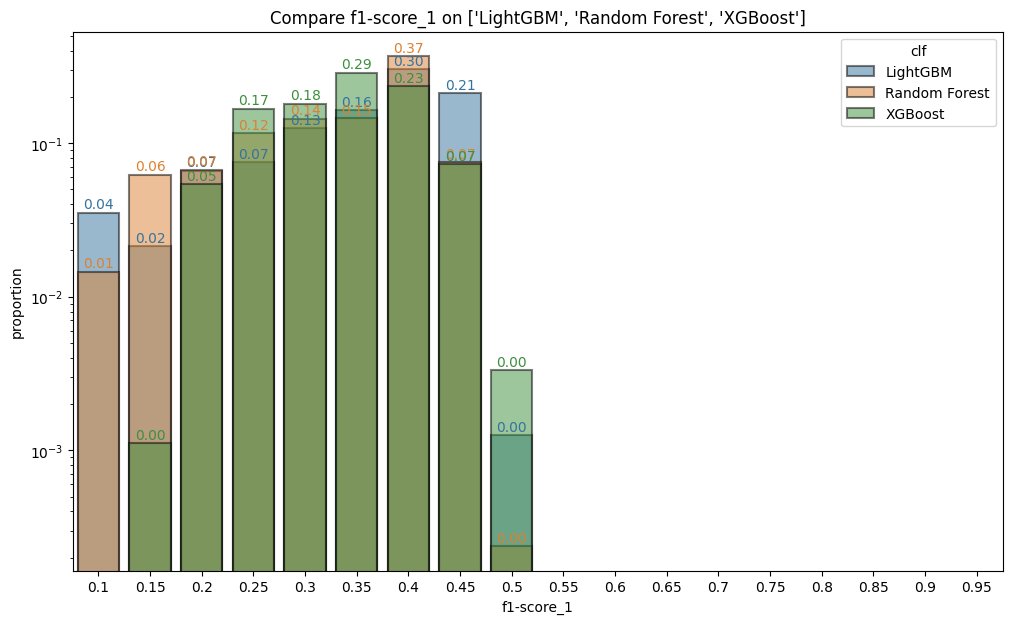

In [315]:
compare_distr(df=df_report, metric='f1-score_1', bins=bins, hue='clf')

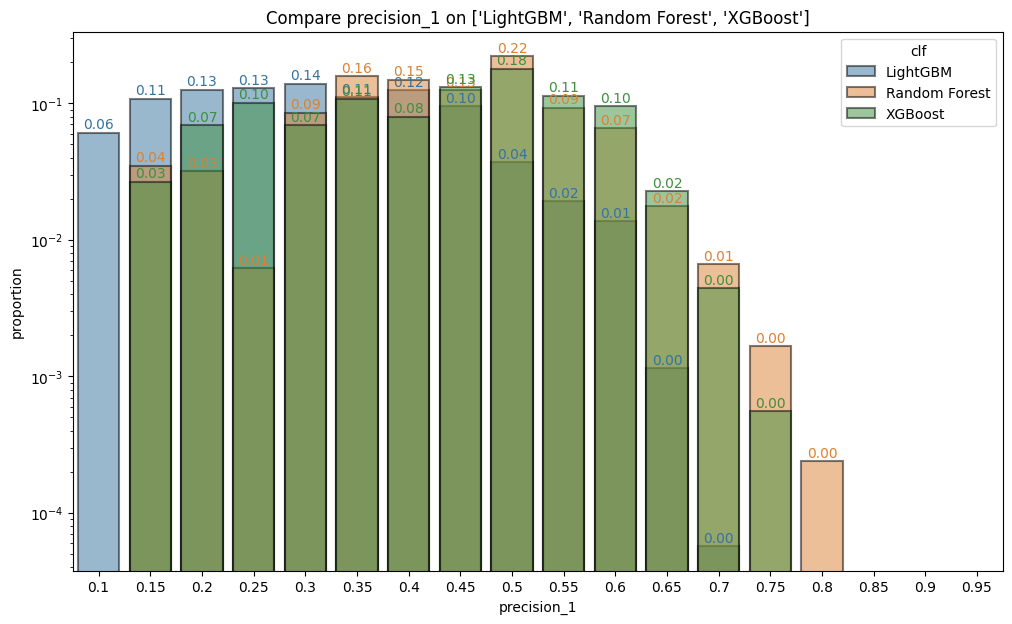

In [316]:
compare_distr(df=df_report, metric='precision_1', bins=bins, hue='clf')

### 4.1.1. Distributions over sampling technique

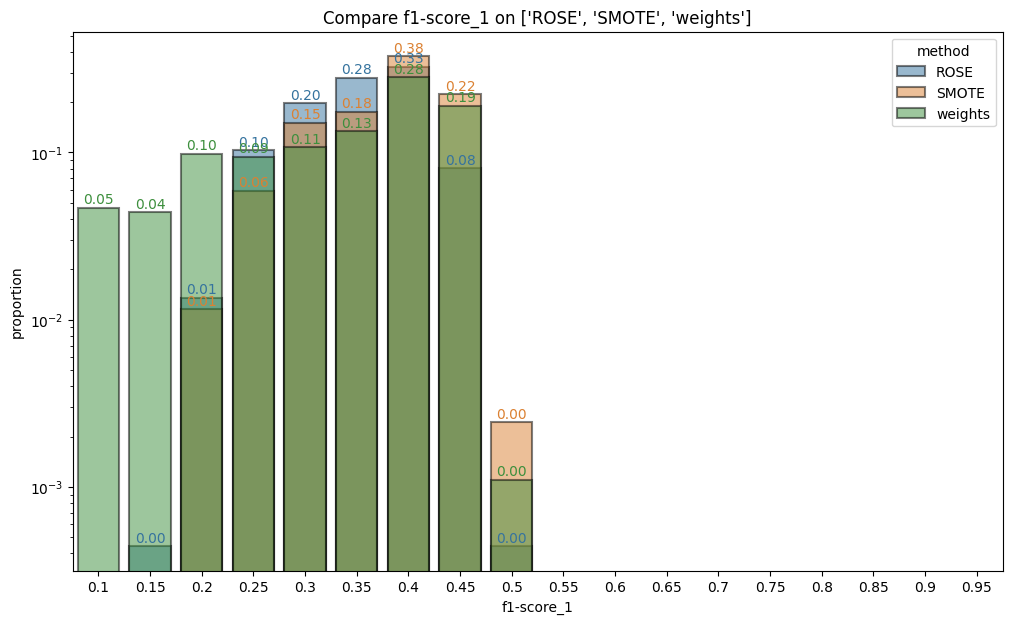

In [311]:
compare_distr(df=df_report, metric='f1-score_1', bins=bins, hue='method')

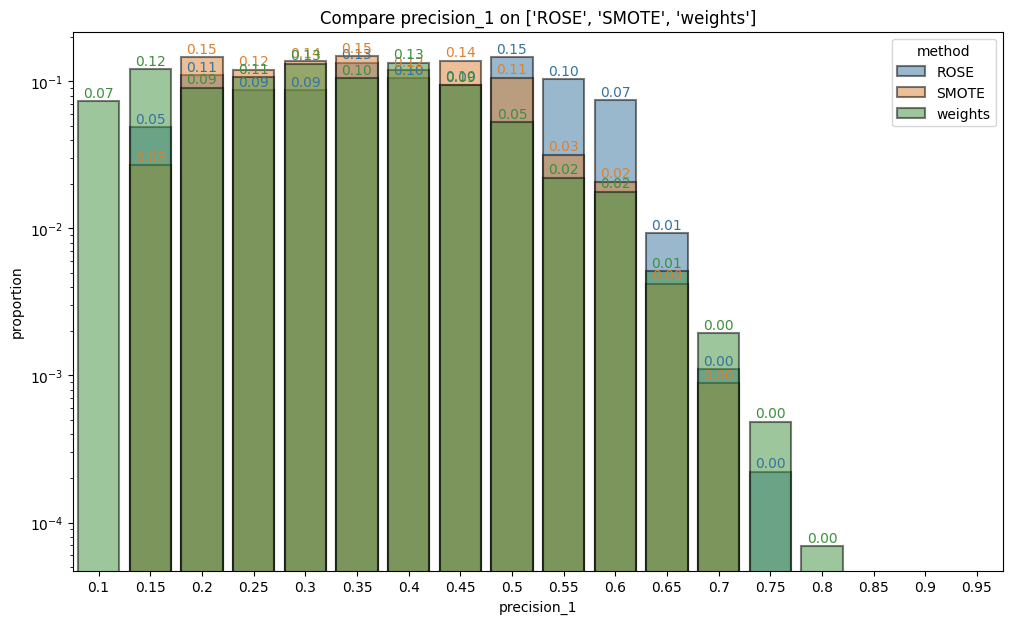

In [317]:
compare_distr(df=df_report, metric='precision_1', bins=bins, hue='method')

## 2. Top setups